In [1]:
import numpy as np

## Part 1

# Batch mode training using least squares - supervised learning of network weights. 


- Implement a radial basis function network from scratch. 

- The network will be used to approximate sin(2x) and square(2x) functions




In [2]:
## Support functions for the evaluation

def getTrainSet(func = 'sin2x', stepSize = 0.1, noise = True):
    ## Returns an 2 x N array of a training set
    # Row 0 = inputs and row 1 = targets¨
    # stepSize is taken as input, range is fixed to 0 --> 2pi. 
    N = int(np.floor(2 * np.pi/stepSize)) #Number of datapoints
    
    train = np.zeros((2,N))
    inputs = np.arange(0, N)
    np.random.shuffle(inputs)
    
    if (noise):
        noise = 1
    else: 
        noise = 0
    
    for step, i in enumerate(inputs):
        train[0, i] = step*stepSize # Input: will be for example 0, 0.1, 0.2 .. 2pi etc.. 
        if (func == 'sin2x'): 
            train[1, i] = np.sin(2*step*stepSize) + noise * np.random.normal(0, np.sqrt(0.1)) # Target: for example sin(2*0), sin(2*0.1) .. sin(2*2pi) etc..
        elif (func == 'step2x'): 
            train[1, i] = np.sign(np.sin(2*step*stepSize)) + noise * np.random.normal(0, np.sqrt(0.1)) # Target: for example sin(2*0), sin(2*0.1) .. sin(2*2pi) etc..

    return train.T

def getTestSet(func = 'sin2x', stepSize = 0.1):
    ## Returns an 2 x N array of a training set
    # Row 0 = inputs and row 1 = targets¨
    # stepSize is taken as input, range is fixed to 0 --> 2pi. 
    N = int(np.floor(2 * np.pi/stepSize)) #Number of datapoints
    
    test = np.zeros((2,N))

    for step in range(N):
        test[0, step] = step*stepSize+0.05 # Input: will be for example 0.05, 0.15, 0.25 .. 2pi´0.05 etc.. 
        if (func == 'sin2x'): 
            test[1, step] = np.sin(2*step*stepSize+0.05) # Target: for example sin(2*0), sin(2*0.1) .. sin(2*2pi) etc..
        elif (func == 'step2x'): 
            test[1, step] = np.sign(np.sin(2*step*stepSize+0.05)) # Target: for example sin(2*0), sin(2*0.1) .. sin(2*2pi) etc..

    return test.T

In [117]:
class RBF:
    def __init__(self, n = 12, variance = 0.1, learning_rate = 0.1, maxinput = 6.28):
        self.n = n # the number of nodes
        self.variance = 0.1 ## Same variance for all nodes
        # self.units = np.random.rand(1, n) * maxinput # random unit position in the input space
        # self.units = np.array([0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6]) # unit positions 
        
        self.units = np.arange(0, maxinput, maxinput/(self.n))
        
        ## One node in each max and minimum
        # self.units = np.arange(0, maxinput, 3.14/2)
        # print("Units: ")
        # print(self.units)
        
        self.n = self.units.shape[0]
        self.w = np.random.rand(1,self.n).T
        self.lr = learning_rate
        #print("Initiated weights, shape: ")
        #print(self.w.shape)
        #
        print("Initiated units: ")
        print(self.units)
        print(self.n)
    
    def error(self, f_approx, f):
        # the average error (with direction +/-)
        if not (f_approx.shape == f.shape): 
            raise Exception('f_approx and f shapes mismatch. f_approx: {}, f: {} '.format(f_approx.shape, f.shape))

        # error = (phi(x) - target)^2
        return np.average(f_approx - f)
    
    def res_error(self, f_approx, f):
        # the residual error (absolute)
        if not (f_approx.shape == f.shape): 
            raise Exception('f_approx and f shapes mismatch. f_approx: {}, f: {} '.format(f_approx.shape, f.shape))

        # error = (phi(x) - target)^2
        return np.average(np.abs(f_approx - f))            
    
    def predict(self, inp):
        # takes an input inp and returns predictions
        # do f^ = phi(x) * w.T
        x = inp.dot(np.ones((1, self.n))) # inp x 1 * 1 x n --> inp x n
        
        # print("n x 1:")
        # print(self.w.shape)
        
        f_approx = self.phi_matrix(x).dot(self.w)
        return f_approx
    
    def fit_lsq(self, inp, f):
        # x is the input. Shape: inputs x 1
        # f is the true value of the function (aka the target), same shape
        if not (inp.shape == f.shape): 
            raise Exception('inp and f shapes mismatch. inp: {}, f: {} '.format(inp.shape, f.shape))
    

        # We want x to be a matrix with shape: inputs x neurons
        x = inp.dot(np.ones((1, self.n))) # inp x 1 * 1 x n --> inp x n
        
        
        # get phi(x)
        self.phi_x = self.phi_matrix(x)

        # we obtain the w that minimizes the error by solving: 
        # phi(x).T * phi(x) * w = phi(x).T * f
        # --> w = (phi(x).T * phi(x))^-1 * phi(x).T * f        
        self.w = np.linalg.inv(self.phi_x.T.dot(self.phi_x)).dot(self.phi_x.T).dot(f)
        
    
    def fit_delta(self, inp, f):
        # x is the input. Shape: inputs x 1
        # f is the true value of the function (aka the target), same shape
        if not (inp.shape == f.shape): 
            raise Exception('inp and f shapes mismatch. inp: {}, f: {} '.format(inp.shape, f.shape))
        
        x = inp.dot(np.ones((1, self.n))) # inp x 1 * 1 x n --> inp x n
        
        # compute phi(x)
        self.phi_x = self.phi_matrix(x)
        
        # make a prediction
        f_approx = self.predict(inp)
        
        # compute the error
        e = self.error(f_approx, f)
        
        # find delta w
        self.dw = -1 * self.lr * e * self.phi_x.T
        
        #print("dw shape")
        #print(dw.shape)

        
        #update weights
        self.w += self.dw
            
    def cl_vanilla_update(self, sample, learning_rate):
        # find the "winner" of the units (the one closest to the random sample)
        unit_distance = np.abs(self.units - sample)
        winner_idx = np.argmin(unit_distance)
        
        # print("CL. Random Sample: {} Winner: {}".format(sample, self.units[winner_idx]))
        
        # how far away is the winner's position from the sample? 
        dp = -1 * learning_rate * (self.units[winner_idx] - sample)
        
        # update the winner's position to be slightly closer to the random sample
        self.units[winner_idx] += dp

    def cl_multi_update(self, sample, learning_rate, winners = 5):
        # by looking for multiple winners, we avoid dead units. 
        
        # find multiple "winners" of the units (the one closest to the random sample)
        unit_distance = np.abs(self.units - sample)
        
        for i in range(winners):
            winner_idx = np.argmin(unit_distance)
            unit_distance[winner_idx] = np.inf # set this distance to inf so its not selected again     
            
            # how far away is the winner's position from the sample? 
            dp = -1 * learning_rate * (self.units[winner_idx] - sample)
            
            # Checked w. this print, seems to work
            # print("CL. Random Sample: {} Winner: {}. Diff: {}. Moving {} to: {}".format(sample, self.units[winner_idx], dp, winner_idx, self.units[winner_idx]+dp))

            # update the winner's position to be slightly closer to the random sample
            self.units[winner_idx] += dp
            

        
        
    def phi(self, x, i): 
        return np.exp(-(np.square(x-i))/(2*np.square(self.variance)))
    
    
    def phi_matrix(self, x):
        # number of inputs (m) (rows) x self.n (n) (columns)
        # print("phi_matrix input size:" + str(x.shape))
        # this is a slow and stupid way of computing phi(x)
        for m in range(x.shape[0]): # m
            for n in range(x.shape[1]): # n
                res = self.phi(x = x[m, n], i = self.units[n])
        #        print("phi({}, {}): {}".format(x[row, col], self.units[0, row], res))
                x[m, n] = res

        return x

In [118]:
function = 'sin2x'

# Train model
trainset = getTrainSet(function, noise = True)

## Test Model
# Get test set
testset = getTestSet(function)

Initiated units: 
[ 0.          0.20933333  0.41866667  0.628       0.83733333  1.04666667
  1.256       1.46533333  1.67466667  1.884       2.09333333  2.30266667
  2.512       2.72133333  2.93066667  3.14        3.34933333  3.55866667
  3.768       3.97733333  4.18666667  4.396       4.60533333  4.81466667
  5.024       5.23333333  5.44266667  5.652       5.86133333  6.07066667]
30
Epoch 5, residual error: 0.14988047192023776, dw: -0.00017853479819043003
Epoch 5, residual error: 0.14988047192023776, dw: -0.00017853479819043003 
[ 0.          0.20933333  0.41866667  0.628       0.83733333  1.04666667
  1.256       1.46533333  1.67466667  1.884       2.09333333  2.30266667
  2.512       2.72133333  2.93066667  3.14        3.34933333  3.55866667
  3.768       3.97733333  4.18666667  4.396       4.60533333  4.81466667
  5.024       5.23333333  5.44266667  5.652       5.86133333  6.07066667]
Initiated units: 
[ 0.          0.20933333  0.41866667  0.628       0.83733333  1.04666667
  1.256

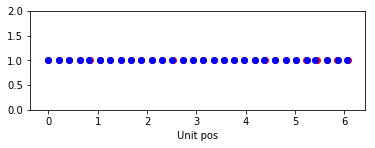

In [136]:


def batch(n, trainset, testset, variance = 0.1):
    model = RBF(n, variance = 0.1)
    
    # fit model
    model.fit_lsq(trainset[:, 0][np.newaxis,:].T, trainset[:, 1][np.newaxis,:].T)
    
    ## Test Model
    # Make predictions
    pred = model.predict(testset[:, 0][np.newaxis,:].T)
    # test error
    e = model.res_error(pred, testset[:, 1][np.newaxis,:].T)

    print("Absolute residual error: {}".format(e))


def delta(n, trainset, testset, variance = 0.1, learning_rate = 0.1, epochs = 20, cl = 'none'):
    model = RBF(n, variance, learning_rate, maxinput = 6.28)
    #fit model
    # for epoch in range(epochs): 
    previous_error = np.inf
    e = np.inf
    epoch = 0
    while e <= previous_error: # while test error decreases
        np.random.shuffle(trainset)
        for tupl in trainset:
            sample = np.array([tupl[0]])[np.newaxis,:].T
            target = np.array([tupl[1]])[np.newaxis,:].T
            model.fit_delta(sample, target)
        
        if (cl == 'vanilla'): 
            # Update units through competetive learning
            rand = np.random.choice(trainset[:, 0])
            model.cl_vanilla_update(rand, 0.1)
        elif (cl == 'multi'): 
            # Update units through competetive learning
            rand = np.random.choice(trainset[:, 0])
            model.cl_multi_update(rand, 0.1, 2)
        
        # Make predictions
        pred = model.predict(testset[:, 0][np.newaxis,:].T)
        # test error
        previous_error = e
        e = model.res_error(pred, testset[:, 1][np.newaxis,:].T)
        epoch += 1
        if (epoch % 5 == 0):
            print("Epoch {}, residual error: {}, dw: {}".format(epoch, e, np.average(model.dw)))
    print("Epoch {}, residual error: {}, dw: {} ".format(epoch, e, np.average(model.dw)))

    print(model.units)
    return model, e
    


units = 30
width = 0.1
lr = 0.25
epochs = 100
# batch(units, trainset, testset, width)
mod1, noise_nocl = delta(units, trainset, testset, width, lr, epochs)
mod2, noise_cl_van = delta(units, trainset, testset, width, lr, epochs, cl = 'vanilla')
mod3, noise_cl_mul = delta(units, trainset, testset, width, lr, epochs, cl = 'multi')
print("Noisy data. No CL: {}".format(noise_nocl))
print("Noisy data. Vanilla CL: {}".format(noise_cl_van))
print("Noisy data. Multi CL: {}".format(noise_cl_mul))

## Compare units
## Scatter Plot
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(211)
# ax.scatter(mod1.units, np.ones(mod1.units.shape), marker = "o", c = 'green')
ax.scatter(mod2.units, np.ones(mod1.units.shape), marker = "o", c = 'red')
ax.scatter(mod3.units, np.ones(mod1.units.shape), marker = "o", c = 'blue')
ax.set(title='',
        xlabel = "Unit pos",
      ylim = (0, 2))
plt.show()

In [127]:
print("Noisy data. No CL: {}".format(noisy_nocl))
print("Noisy data. With CL: {}".format(noisy_cl))
print("Noisy data. No CL: {}".format(clean_nocl))
print("Noisy data. CL: {}".format(clean_cl))

Noisy data. No CL: 0.4415473107039592
Noisy data. With CL: 0.23859607373295577
Noisy data. No CL: 0.04462424426494158
Noisy data. CL: 0.04829242257684326


### Minimizing the residual error

With 12 units evenly distributed, variance = 0.1, the Absolute residual error was: 0.32240
the error did not change significantly with variance 0.3 or 0.01


With 20 units evenly distributed, variance = 0.1, the Absolute residual error was: 0.131492


Adding a node in the very end of the interval reduced it somewhat to 0.12314

30 units: 0.03243

40 units: 0.0313 





In [100]:
np.arange(0, 6.28, 6.28/11)

array([ 0.        ,  0.57090909,  1.14181818,  1.71272727,  2.28363636,
        2.85454545,  3.42545455,  3.99636364,  4.56727273,  5.13818182,
        5.70909091])

array([[ 0.94593827,  0.50419356,  0.57720877,  0.45551226,  0.42067183]])

array([[-0.05406173, -0.49580644, -0.42279123, -0.54448774, -0.57932817]])